# Library

In [253]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import IPython.display

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from PIL import Image
from glob import glob
import scipy as sp
import numpy as np
import pandas as pd
#import Pyvips

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle

import torchvision

from tqdm.auto import tqdm
from tqdm import trange
from time import sleep
from functools import partial
import tifffile as tiff

import cv2 as cv
from openslide import OpenSlide
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms
import torch.optim as optim
import gc
import torchvision.models as models
import copy


OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

from torch.cuda.amp import autocast, GradScaler
Image.MAX_IMAGE_PIXELS = None
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [254]:
del model_ft
gc.collect()
print(torch.cuda.max_memory_allocated(device=device))
torch.cuda.empty_cache()


16120054784


# Loading data

In [255]:
transformed_train = pd.read_csv('../input/mayo-clinic-output/new_train.csv')
classes_name = ["LAA","CE"]

# Data Loader

In [256]:
class TrainDataset(Dataset):
    def __init__(self, path, df, transform=None):
        self.df = df
        self.path = path
        self.Image_names = df['image_name'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.Image_names[idx]
        img= Image.open(os.path.join(self.path, f"{file_name}.jpg"))
        if self.transform:
            image=self.transform(img)

        label = self.labels[idx]

        return image, torch.tensor(label)

# Transforms

In [257]:
batch_size=80
data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = TrainDataset("../input/mayo-clinic-output/", transformed_train, transform = data_transform)
#vaild_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", vaild, transform = data_transform)
#test_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", test, transform = data_transform)

data_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)
#data_loader_vaild = torch.utils.data.DataLoader(vaild_dataset,
#                                             batch_size=batch_size, shuffle=True,
#                                             num_workers=0)


# PreTrained Model

In [258]:
"""model_ft = models.densenet121(pretrained=True)
model_ft=model_ft.to(device)
model_ft.fc = nn.Linear(1024, 2)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

"""

'model_ft = models.densenet121(pretrained=True)\nmodel_ft=model_ft.to(device)\nmodel_ft.fc = nn.Linear(1024, 2)\ncriterion = nn.CrossEntropyLoss()\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)\nexp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n\n'

In [260]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft=model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



2048


# Training

In [261]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        with tqdm(data_loader, unit="batch") as tepoch:
            e=epoch+1
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # bacoptimizerkward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(data_loader)
                epoch_acc = running_corrects.double() / len(data_loader)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                # deep copy the model
            print()
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [262]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)


  0%|          | 0/66 [00:00<?, ?batch/s]

Epoch 0/0
----------
train Loss: 53.2475 Acc: 53.1515
val Loss: 42.2812 Acc: 59.2273

Training complete in 1m 28s


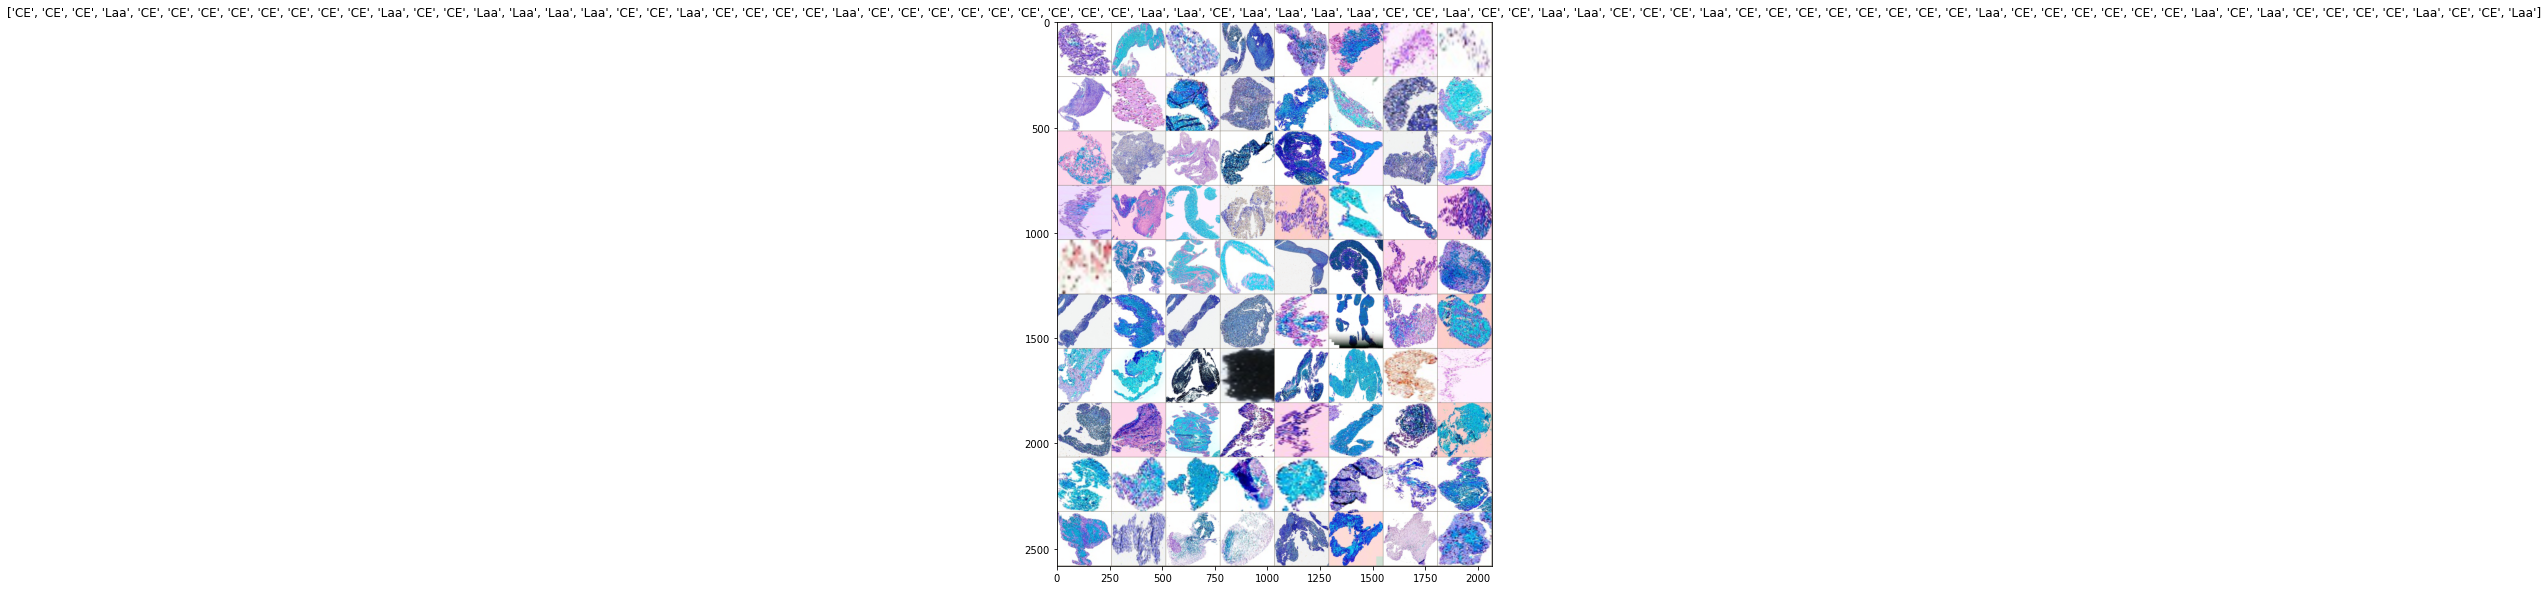

In [263]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(100,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes_name[x] for x in classes])

In [264]:
def visualize_model(model, num_images=40):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            print(outputs.shape)
            _, preds = torch.max(outputs, 1)
            print(preds)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_name[preds[j]]} Actual: {classes_name[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        

        model.train(mode=was_training)


In [265]:
visualize_model(model_ft)

torch.Size([80, 3])
tensor([2, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2,
        0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0,
        2, 2, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0,
        2, 0, 2, 2, 2, 2, 1, 1], device='cuda:0')


IndexError: list index out of range

In [ ]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)